# Practical session n°5:

##Part I: Quantile Regression with Neural networks.

* Adapted Cost Function
* Two examples with FCN
* A simultaneous quantile regression

##Part II: Sampling with GANs.

* Basic Principle and First Training
* Limitations
* A Wasserstein GAN

Duration: 4 hours

### Partie I: quantile regression   

In this part, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [13]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 399 (delta 122), reused 141 (delta 93), pack-reused 210
Receiving objects: 100% (399/399), 77.81 MiB | 32.83 MiB/s, done.
Resolving deltas: 100% (162/162), done.


**Exercise 1**: an adapted cost function

As seen in the previous practical session n°3, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

In [14]:
os.chdir('ml-student/TP5')
# from utils_TP5 import gen_proba

from utils_TP5 import *
from utils_TP5_exo3 import *

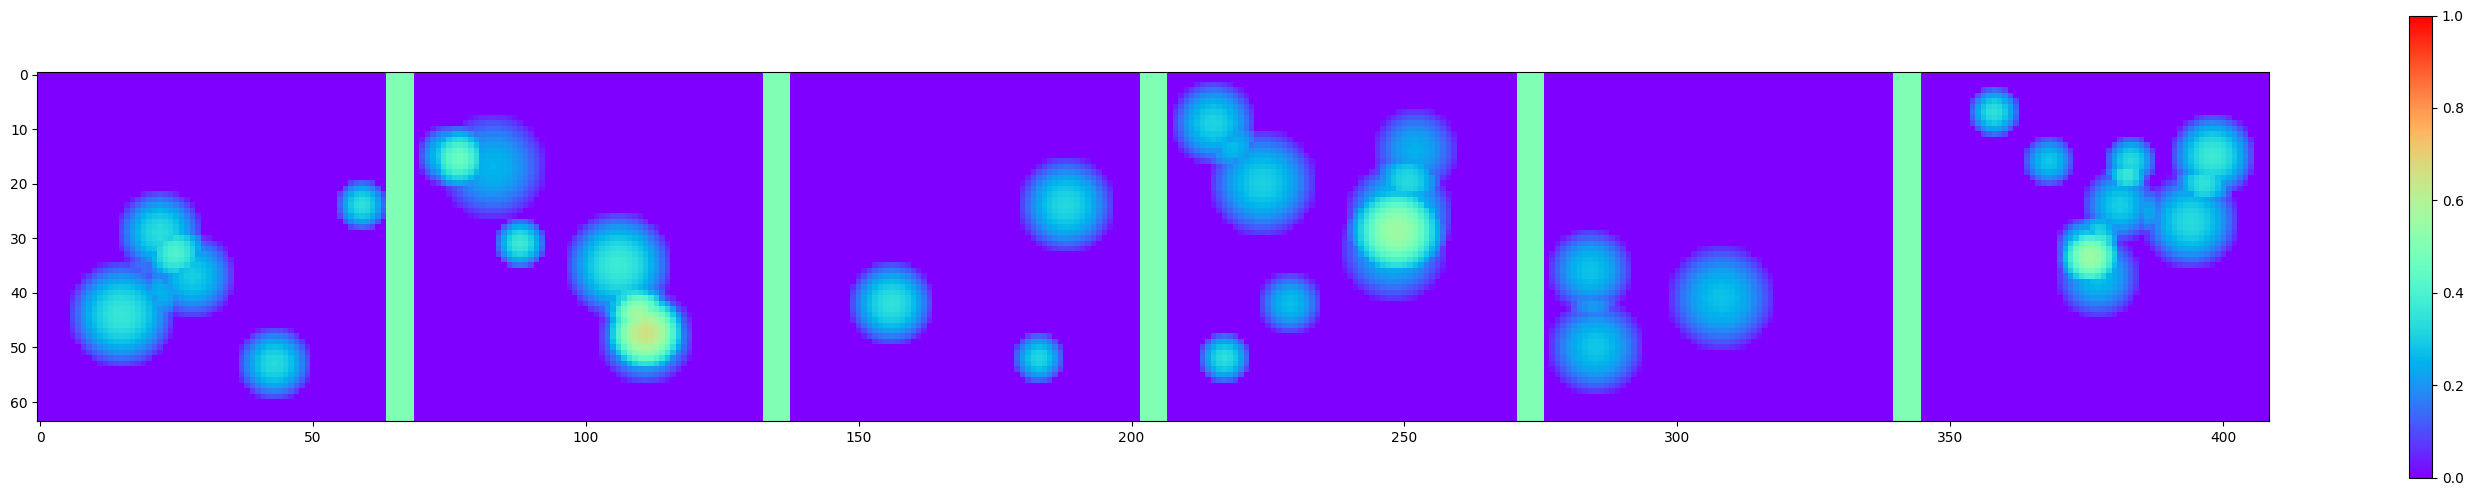

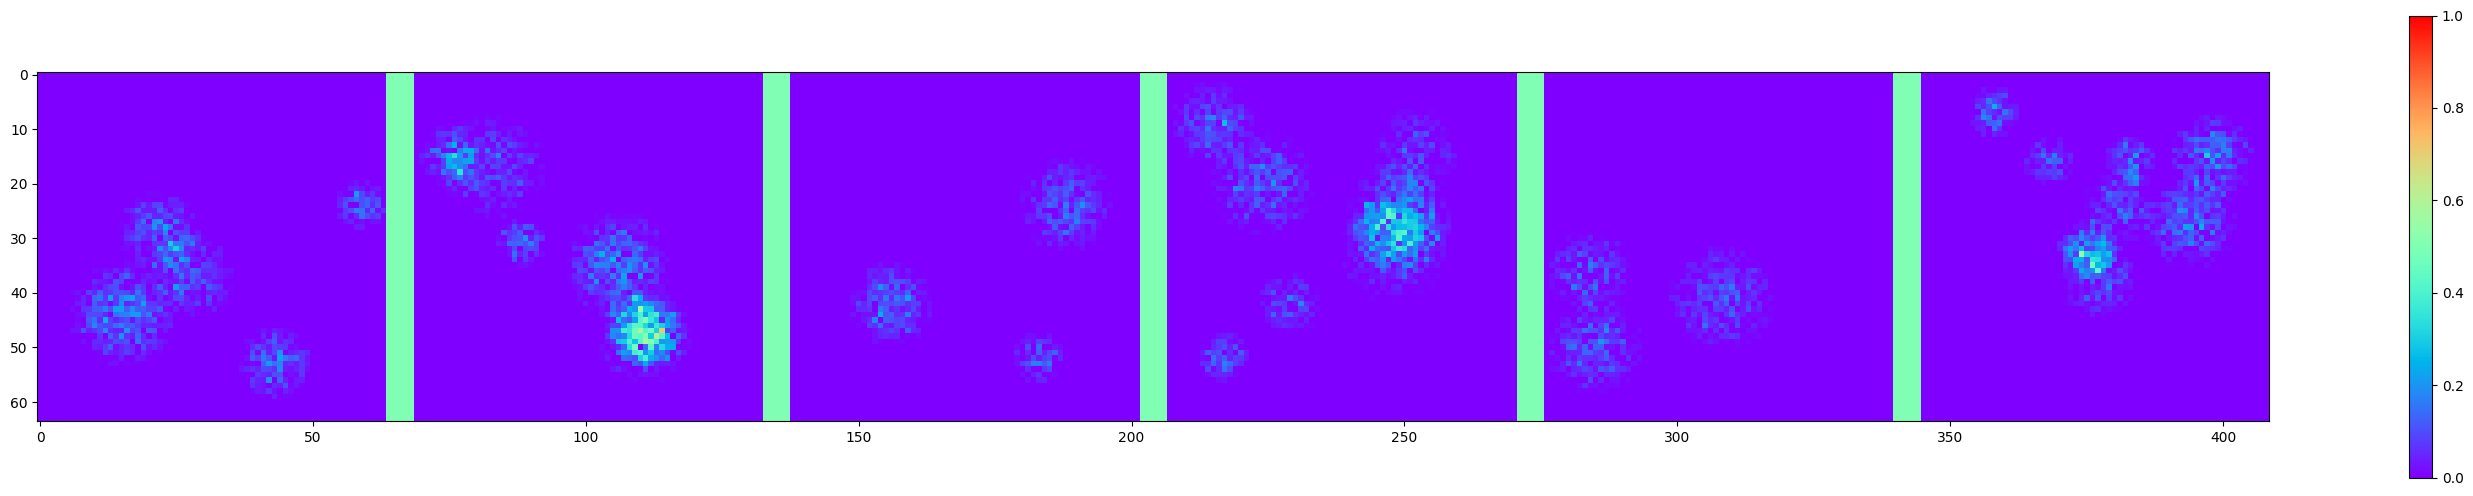

In [15]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y)$$
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

In [16]:
# def rho(t,u):
#   return t * max(u, 0) + (t - 1) * min(u, 0)

# tps = [0, 0.3, 0.5, 0.7, 1]

# u = np.linspace(-4, 4, 100)

# def rho0(u):
#   return rho(0, u)

# plt.plot(u, rho0(u))
# plt.show()

One can show (see accompanying exercise sheet for the practical session) that the value of $z$ that minimizes the expectation $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , z) ]$ is the $t$-th quantile of the distribution of $y_{i,j}$.

In the context where the value $y_{i,j}$  depends on the image $x$, minimizing $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , f^\theta_{i,j}(x))]$ will therefore constrain the network $f^\theta$ to provide the $t$-th quantile of $p(y_{i,j} | x)$.

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles.

In [17]:
t = 0.9

def rho(u,t):
        loss = t * torch.clamp(u, min = 0.) + (t - 1) * torch.clamp(u, max = 0.)
        loss = torch.mean(loss)
        return loss

def criterion(output, target):
  return rho(target-output, t)

**Q3** Train a U-Net to estimate the ninth decile.

In [18]:
fcn = UNet(1, 1, 8)
fcn = fcn.cuda()
epoch = 50
nbatches = 100
batchsize = 64

optimizer = torch.optim.Adam(fcn.parameters(), 0.001)


train_losses = []

for epoch in range(epoch):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_proba(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.0077609783
Epoch 1
epoch loss : 

0.0026747293
Epoch 2
epoch loss : 

0.002407534
Epoch 3
epoch loss : 

0.002024702
Epoch 4
epoch loss : 

0.002036464
Epoch 5
epoch loss : 

0.0020816415
Epoch 6
epoch loss : 

0.0019808928
Epoch 7
epoch loss : 

0.0018359785
Epoch 8
epoch loss : 

0.0020731336
Epoch 9
epoch loss : 

0.0019053577
Epoch 10
epoch loss : 

0.0019298795
Epoch 11
epoch loss : 

0.0019028037
Epoch 12
epoch loss : 

0.0018696571
Epoch 13
epoch loss : 

0.0019229415
Epoch 14
epoch loss : 

0.0019331571
Epoch 15
epoch loss : 

0.0018526479
Epoch 16
epoch loss : 

0.0019602405
Epoch 17
epoch loss : 

0.0018093889
Epoch 18
epoch loss : 

0.0018541886
Epoch 19
epoch loss : 

0.0017172641
Epoch 20
epoch loss : 

0.0018726134
Epoch 21
epoch loss : 

0.0018357021
Epoch 22
epoch loss : 

0.0018328088
Epoch 23
epoch loss : 

0.0019244078
Epoch 24
epoch loss : 

0.001947182
Epoch 25
epoch loss : 

0.0019248648
Epoch 26
epoch loss : 

0.0019338287
Epoch 27
epoch 

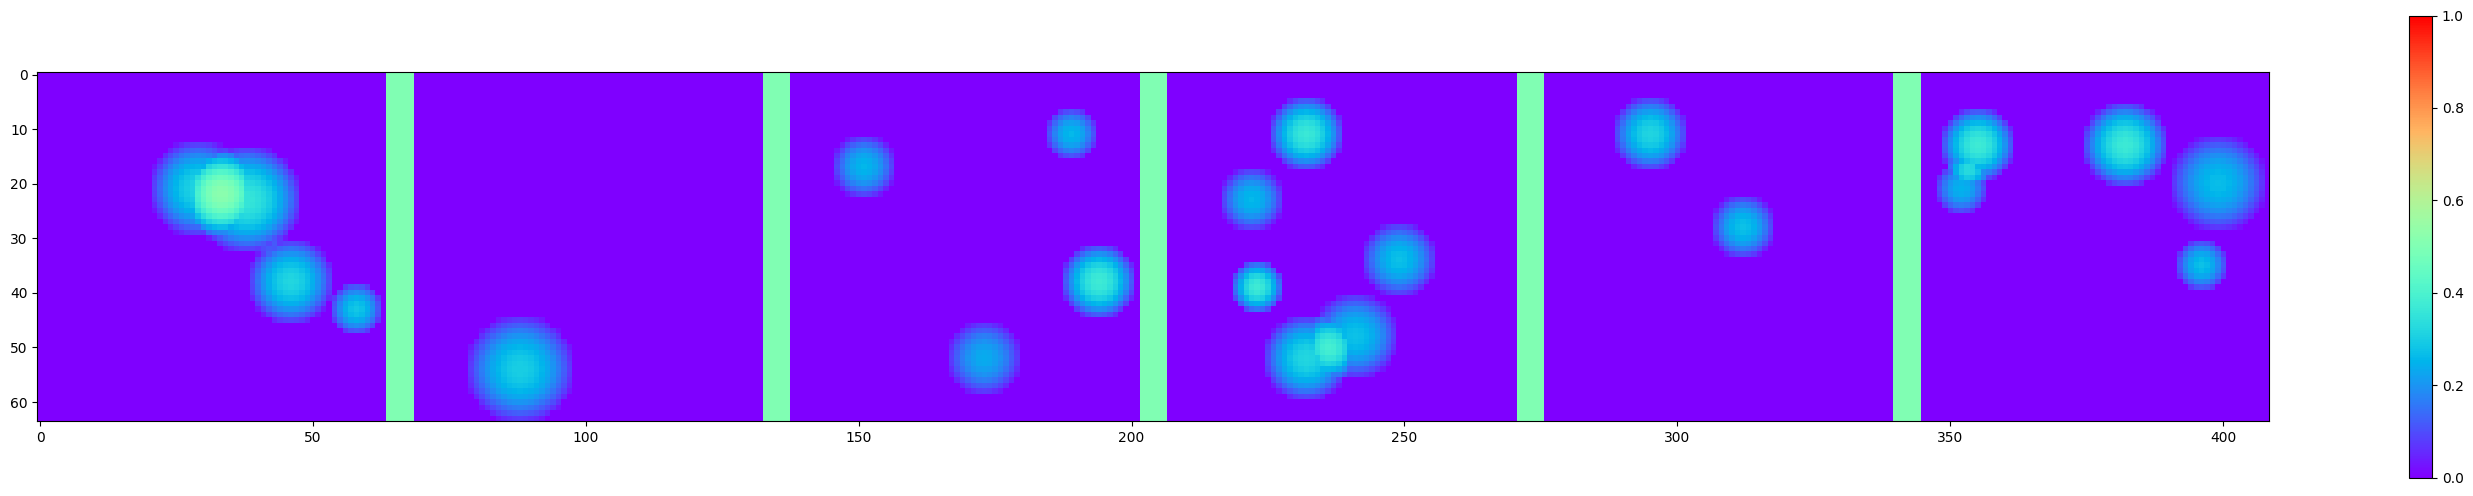

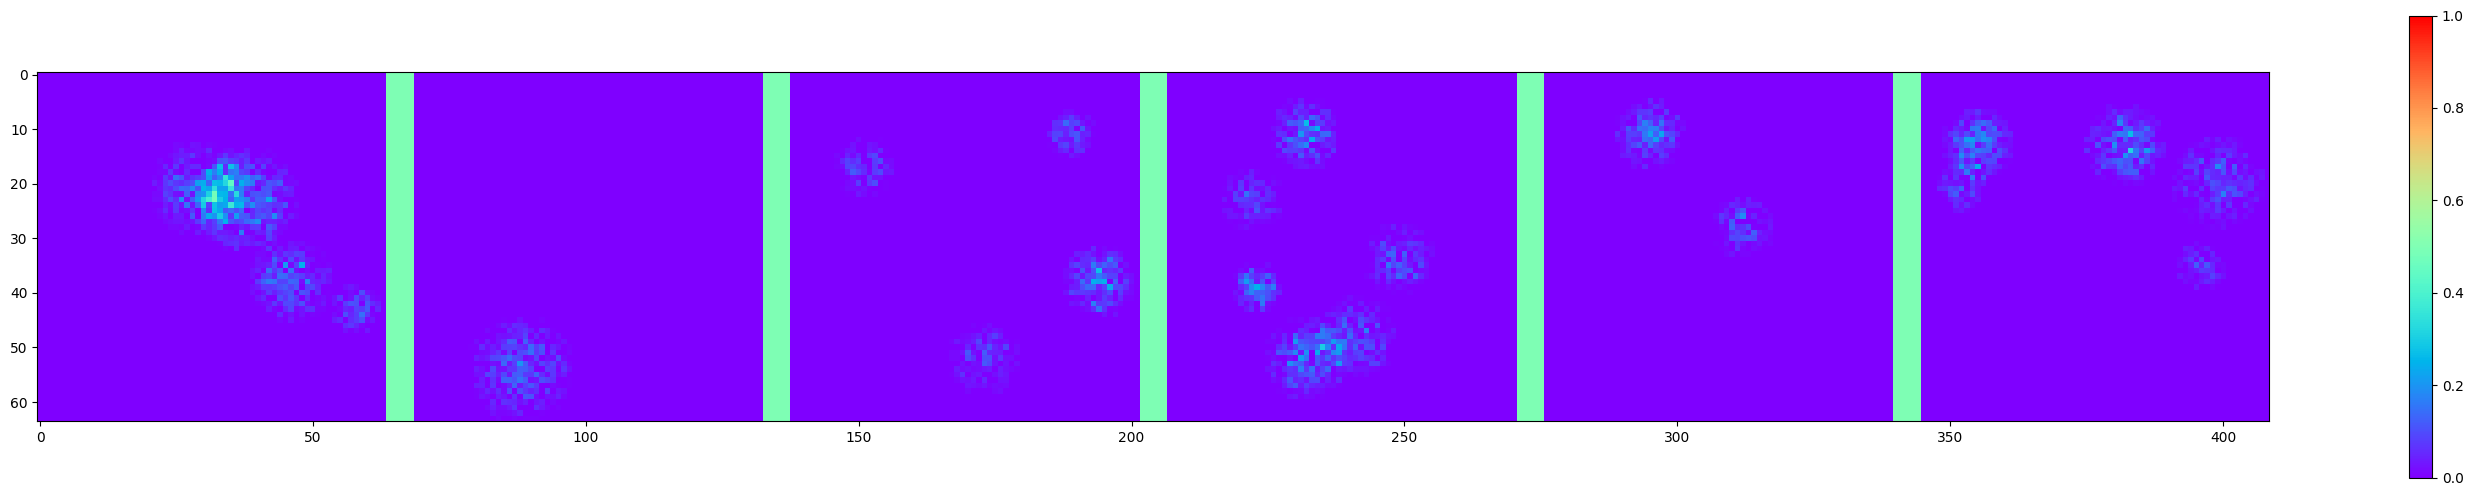

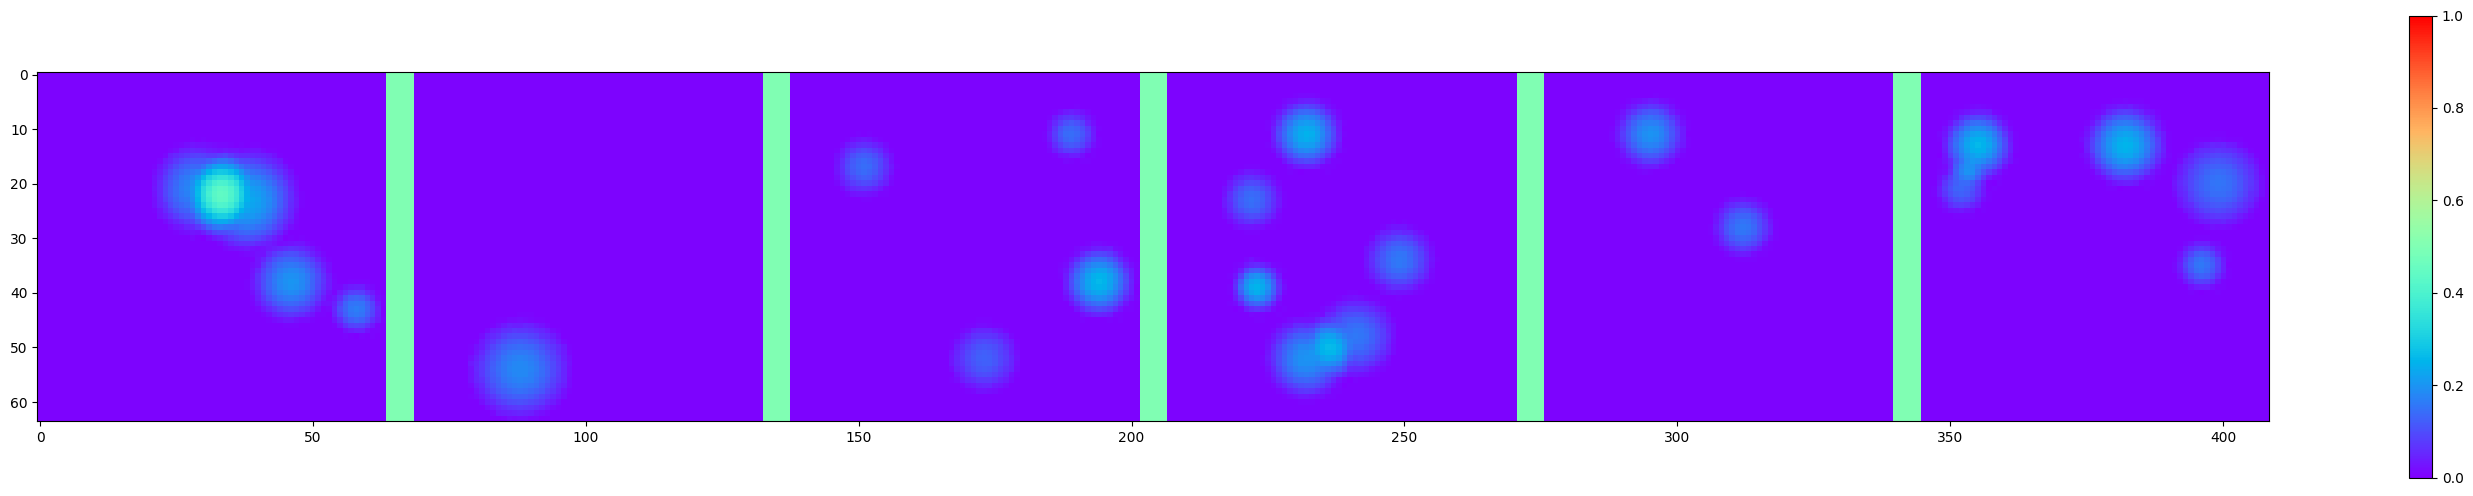

In [19]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

input = input.cuda()

fcn.eval()

output = fcn(input)

output = output.cpu().detach()

fig2 = plt.figure(2, figsize=(36,6))
voir_batch2D(output, 6, fig2, k = 0, min_scale = 0, max_scale = 1)

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

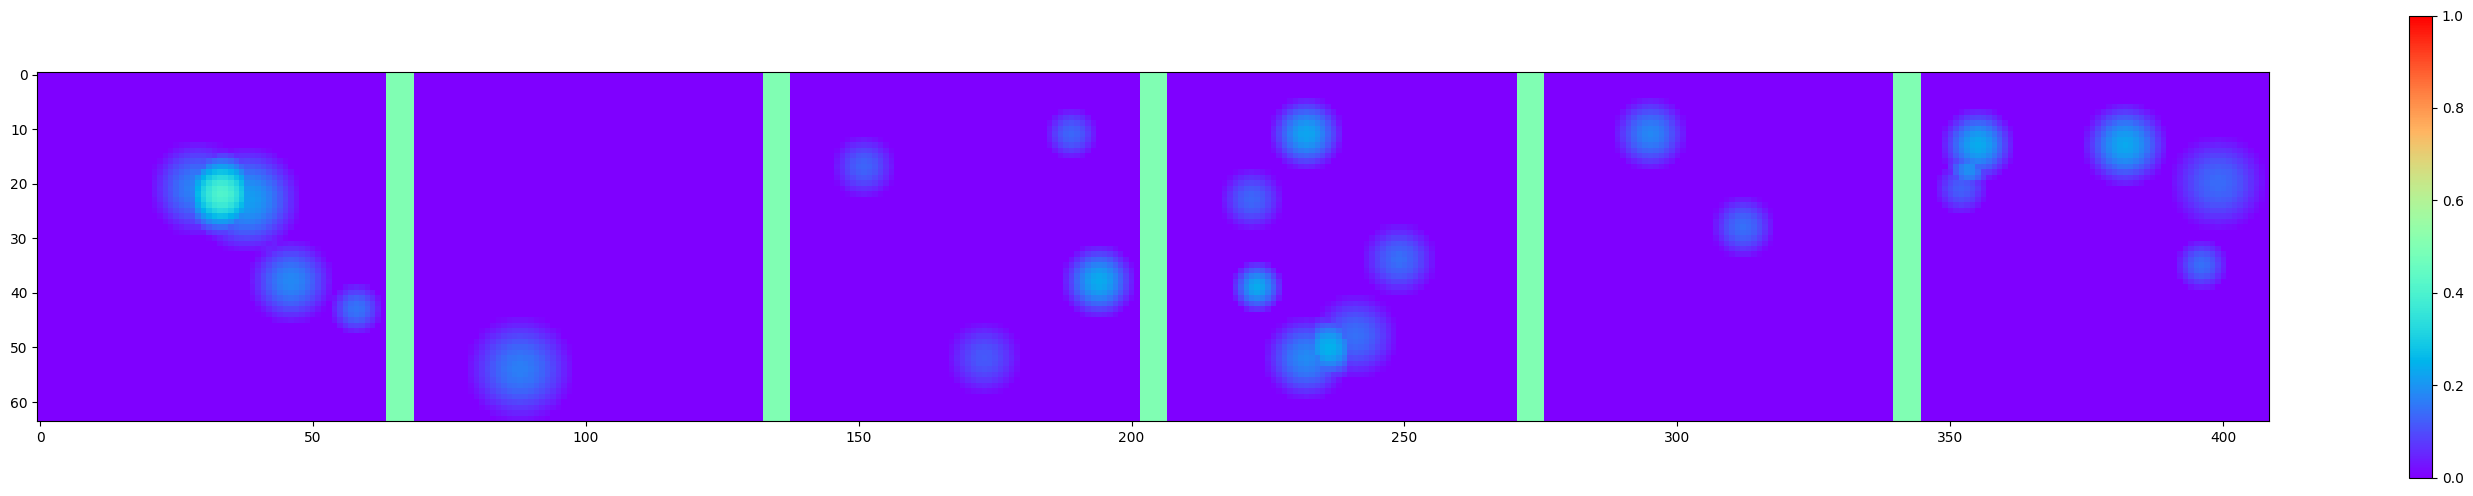

In [20]:
input = input.cpu()
m = torch.distributions.normal.Normal(input**2, 0.2 * input + 0.000001, validate_args = None)
quantile = m.icdf(0 * input + 0.9)
fig3 = plt.figure(3, figsize=(36,6))
voir_batch2D(quantile, 6, fig3, k = 0, min_scale = 0, max_scale = 1)

**Exercise 2**: a trickier dependence

Let's now work with the *gen_proba_2* function. Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

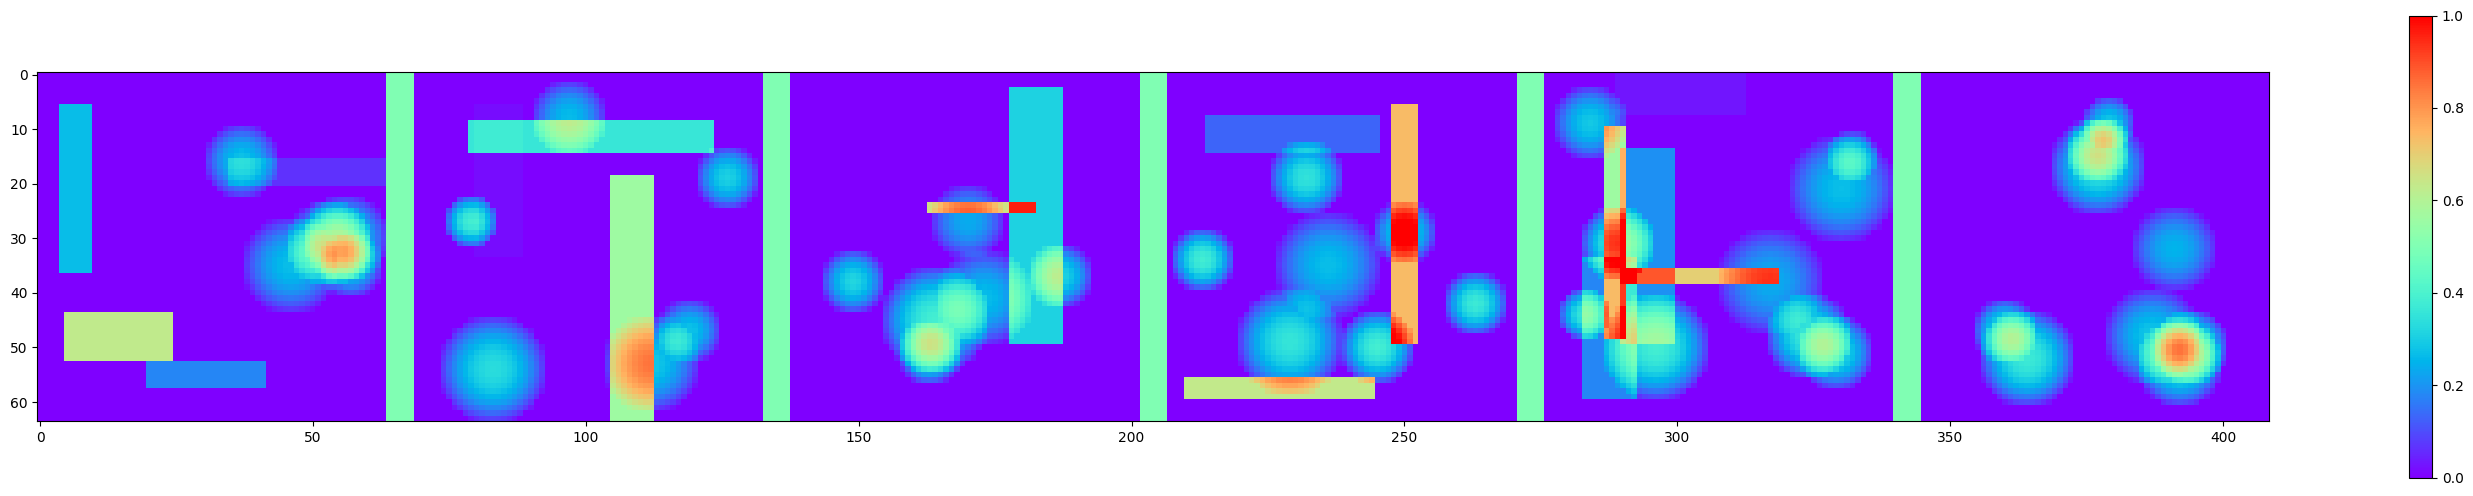

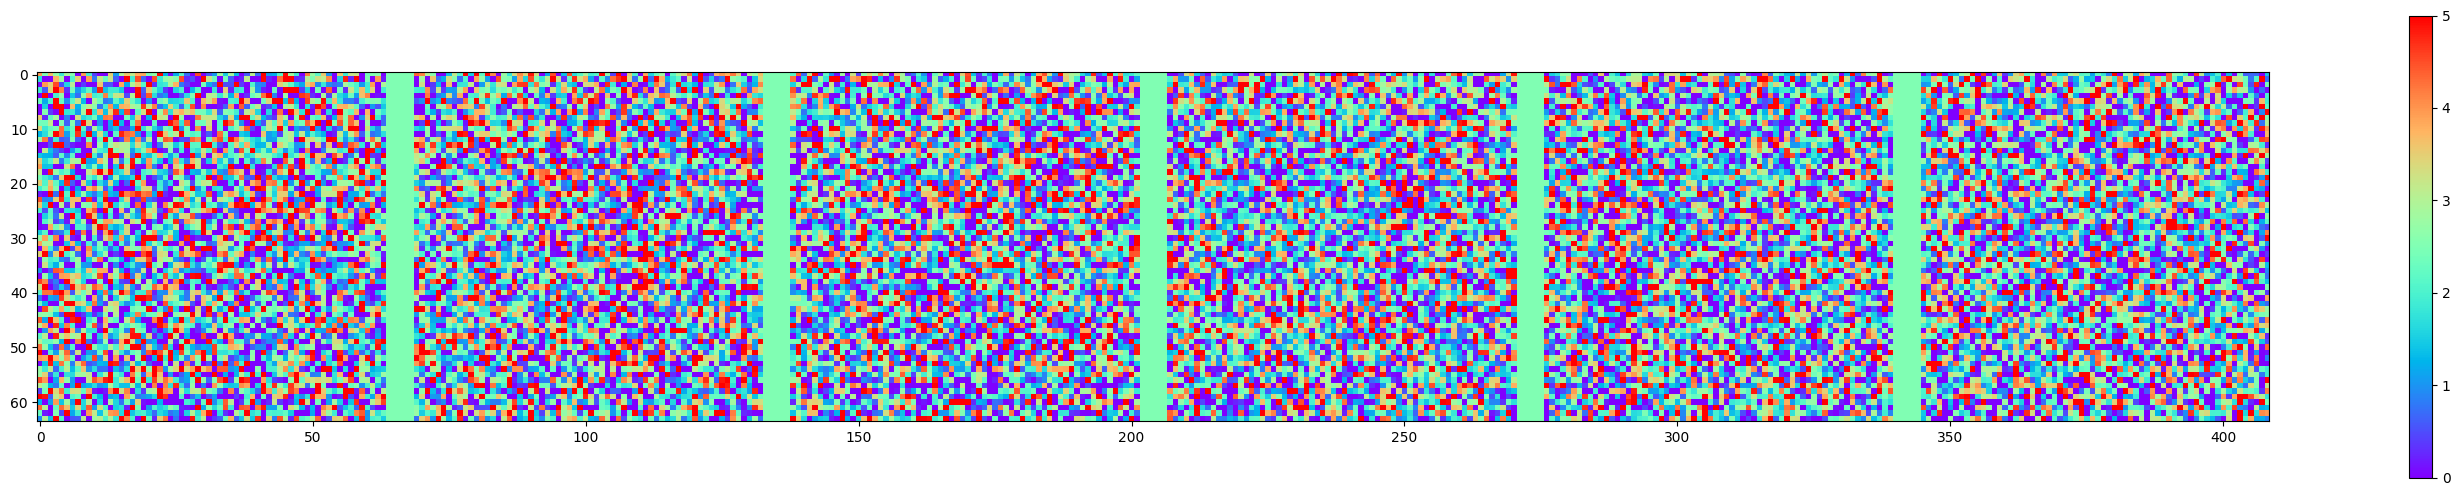

In [21]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

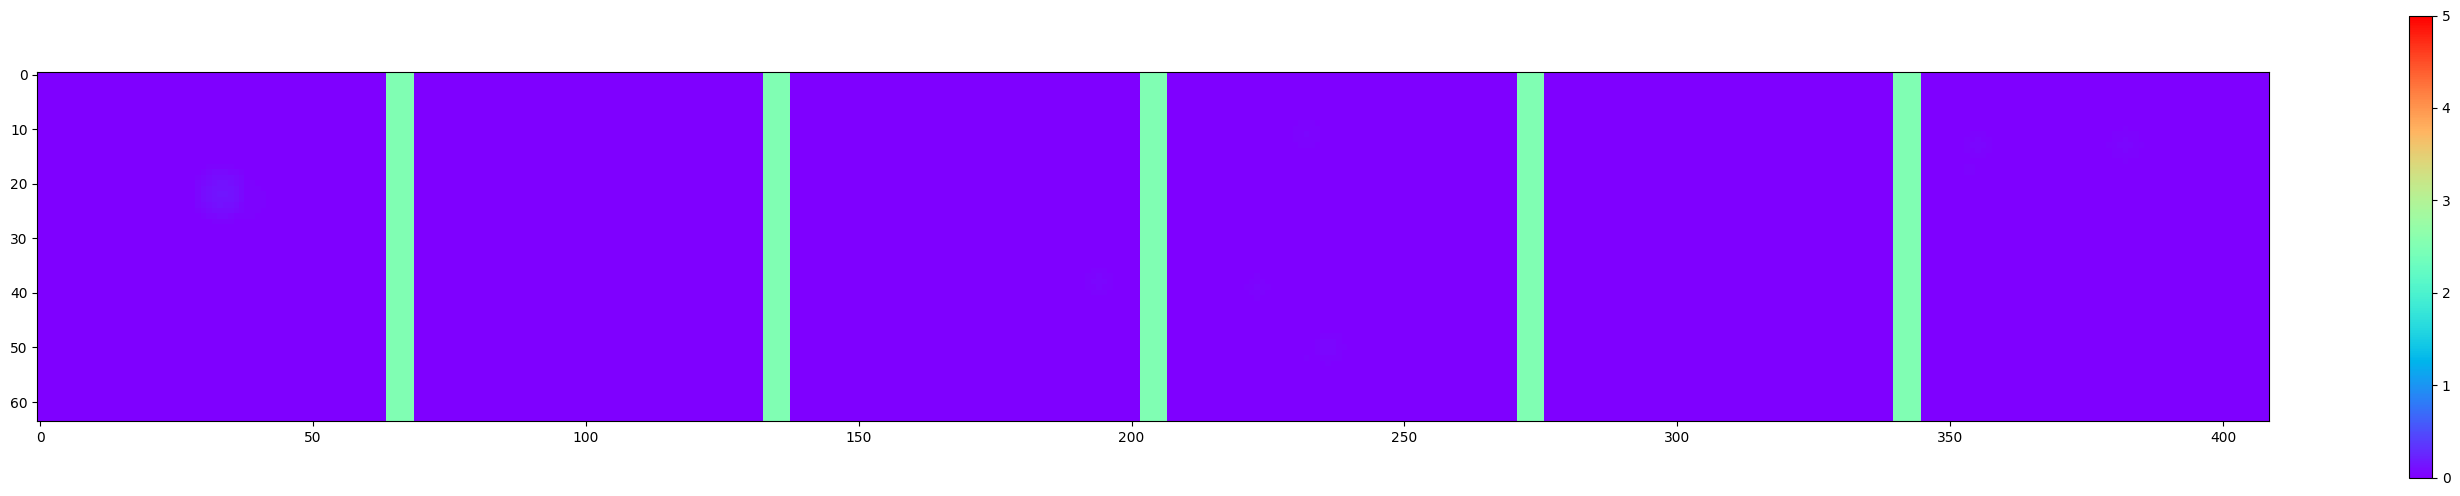

In [22]:
quantile1 = m.icdf(0 * input + 0.1)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(quantile1, 6, fig2, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [23]:
t = 0.1

def rho(u,t):
        loss = t * torch.clamp(u, min = 0.) + (t - 1) * torch.clamp(u, max = 0.)
        loss = torch.mean(loss)
        return loss

def criterion(output, target):
  return rho(target-output, t)

In [24]:
fcn = UNet(1, 1, 8)
fcn = fcn.cuda()
epoch = 50
nbatches = 100
batchsize = 64

optimizer = torch.optim.Adam(fcn.parameters(), 0.001)


train_losses = []

for epoch in range(epoch):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_proba_2(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.36850154
Epoch 1
epoch loss : 

0.3661785
Epoch 2
epoch loss : 

0.36611572
Epoch 3
epoch loss : 

0.36591813
Epoch 4
epoch loss : 

0.36587375
Epoch 5
epoch loss : 

0.36583936
Epoch 6
epoch loss : 

0.3657201
Epoch 7
epoch loss : 

0.3658791
Epoch 8
epoch loss : 

0.36589622
Epoch 9
epoch loss : 

0.36573368
Epoch 10
epoch loss : 

0.36574686
Epoch 11
epoch loss : 

0.36575767
Epoch 12
epoch loss : 

0.36552006
Epoch 13
epoch loss : 

0.3658917
Epoch 14
epoch loss : 

0.3659735
Epoch 15
epoch loss : 

0.3656565
Epoch 16
epoch loss : 

0.36595863
Epoch 17
epoch loss : 

0.3658593
Epoch 18
epoch loss : 

0.36586732
Epoch 19
epoch loss : 

0.3656457
Epoch 20
epoch loss : 

0.36582124
Epoch 21
epoch loss : 

0.36590055
Epoch 22
epoch loss : 

0.36571026
Epoch 23
epoch loss : 

0.36562106
Epoch 24
epoch loss : 

0.3658364
Epoch 25
epoch loss : 

0.36593315
Epoch 26
epoch loss : 

0.36581993
Epoch 27
epoch loss : 

0.36578003
Epoch 28
epoch loss : 

0.36573133
Epoc

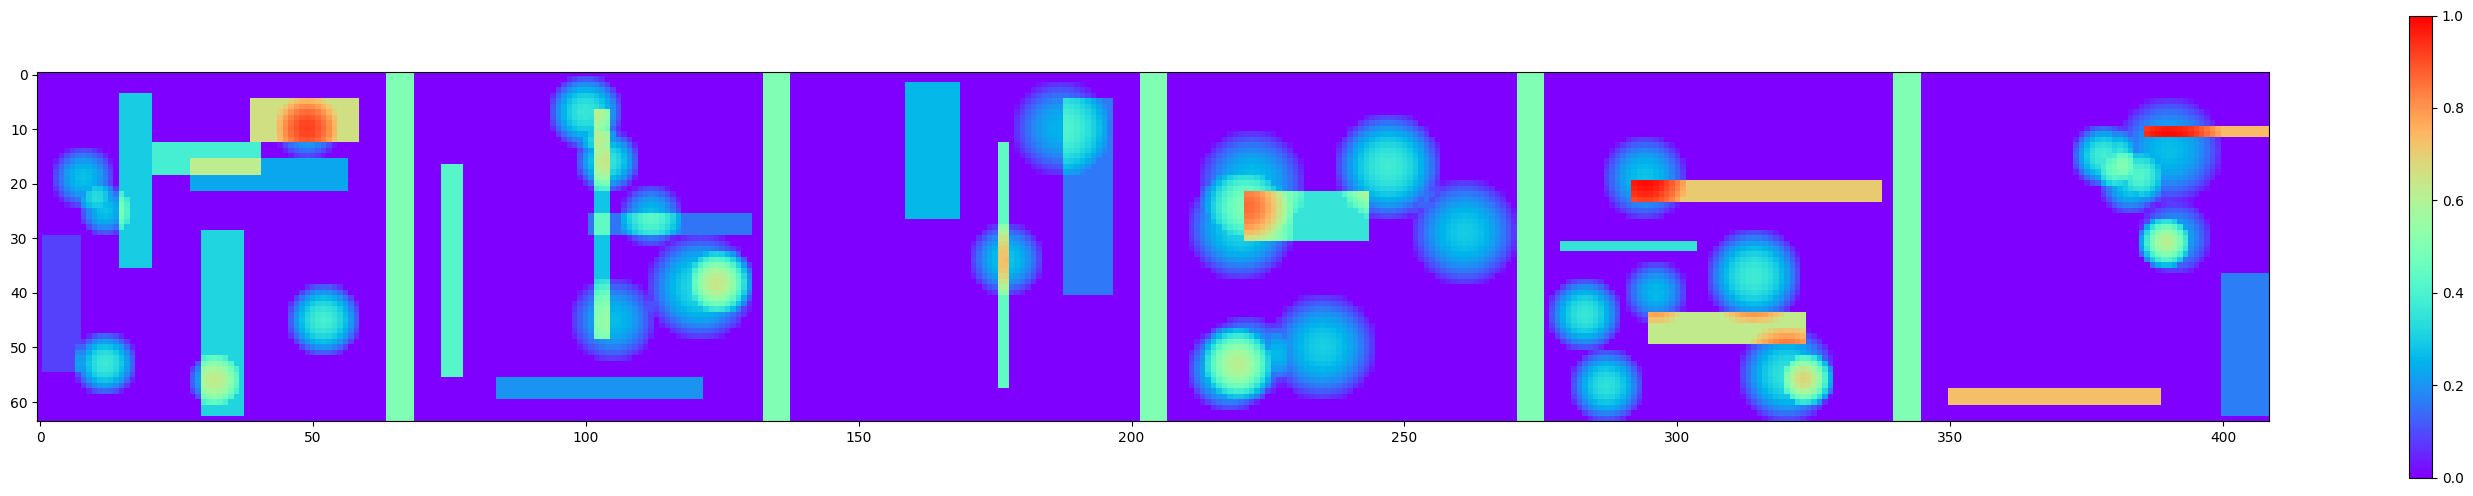

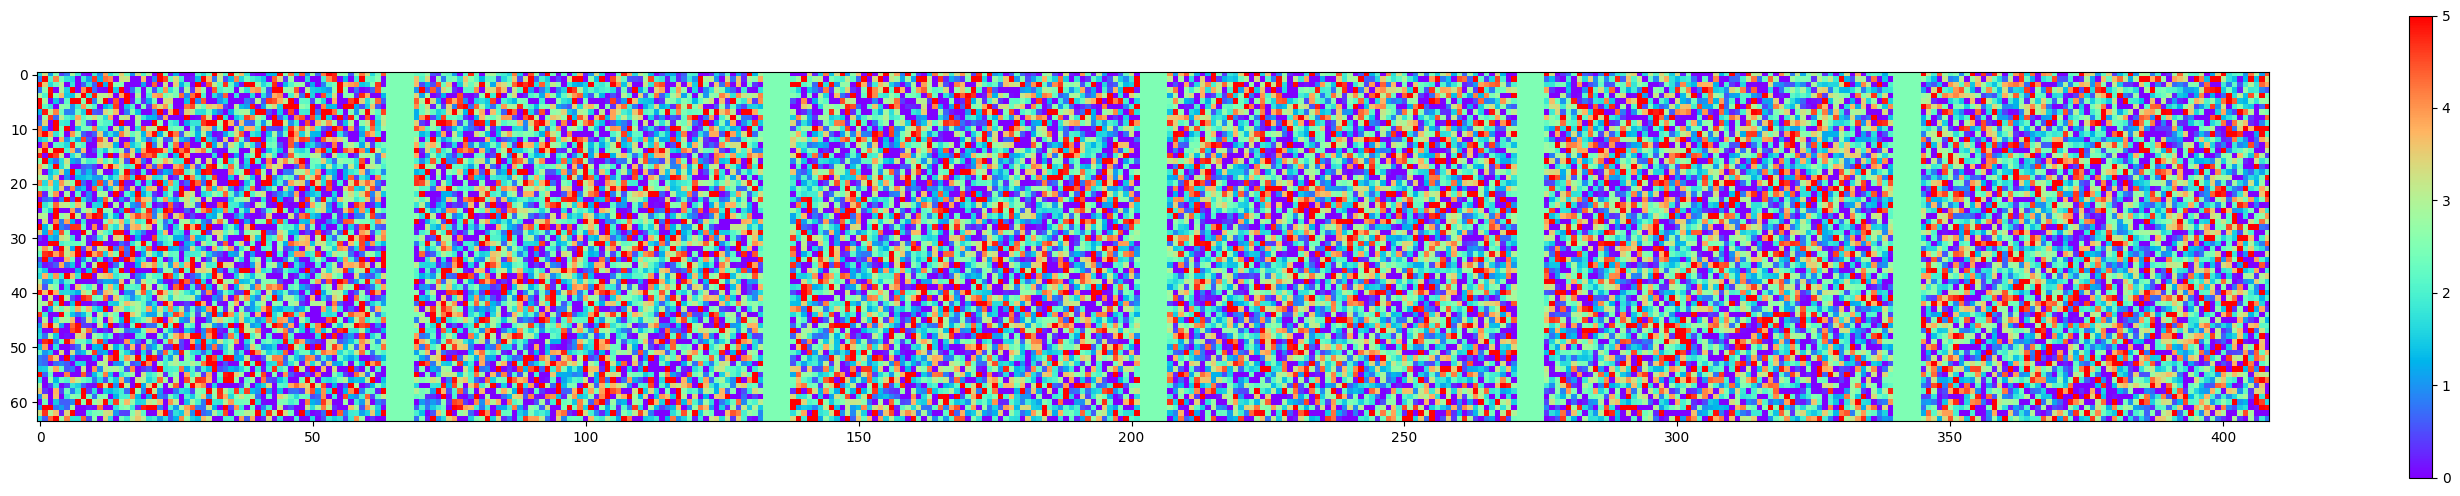

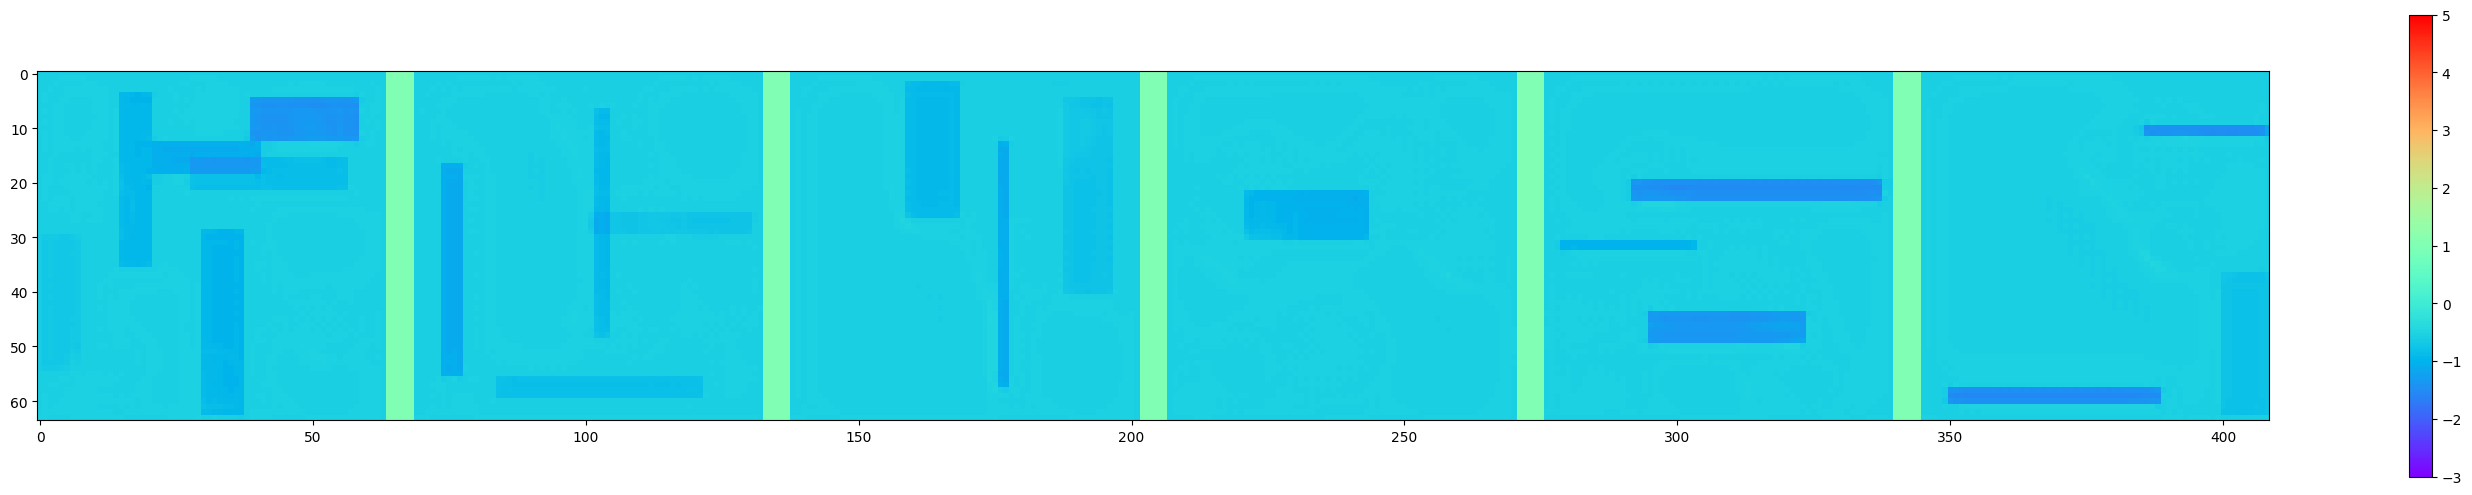

In [25]:
# sampling (x,y) :

input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

input = input.cuda()

fcn.eval()

output = fcn(input)

output = output.cpu().detach()

fig2 = plt.figure(2, figsize=(36,6))
voir_batch2D(output, 6, fig2, k = 0, min_scale = -3, max_scale = 5)

**Q2** Do we have a dependance ? Is it still a pixel-wise dependence (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)?

**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

In [50]:
# def dot(t, M):
#   M_prime = 0
#   c = M.size(dim = 1)
#   for i in range(c):
#     M_prime += t[i] * M[:, i, :, :]

def dot(t, M):
	return (M * t.view((1,t.shape[0],1,1)) ).sum(dim=1)

In [51]:
def rhotc(u,tc):
        loss = dot(tc, torch.clamp(u, min = 0.))
        loss += dot(tc - 1, torch.clamp(u, max = 0.))
        loss = torch.mean(loss)
        return loss

def criteriontc(d,tc):
  return rhotc(d, tc)

**Q2** Complete the class *QuantileLoss*:

In [52]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output
        # loss_by_pix =
        loss = criteriontc(d, self.t)

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.

In [53]:
fcn = UNet(1, n - 1, 32)
fcn = fcn.cuda()
epoch = 100
nbatches = 100
batchsize = 64
n = 100
ql = QuantileLoss(n)

optimizer = torch.optim.Adam(fcn.parameters(), 0.001)


train_losses = []

for epoch in range(epoch):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_proba(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = ql.forward(output, target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

1.9051659
Epoch 1
epoch loss : 

0.39058968
Epoch 2
epoch loss : 

0.32596081
Epoch 3
epoch loss : 

0.30163002
Epoch 4
epoch loss : 

0.2781629
Epoch 5
epoch loss : 

0.2762971
Epoch 6
epoch loss : 

0.26963365
Epoch 7
epoch loss : 

0.26259583
Epoch 8
epoch loss : 

0.25225538
Epoch 9
epoch loss : 

0.24324977
Epoch 10
epoch loss : 

0.24389191
Epoch 11
epoch loss : 

0.2348159
Epoch 12
epoch loss : 

0.23285417
Epoch 13
epoch loss : 

0.23013753
Epoch 14
epoch loss : 

0.23108925
Epoch 15
epoch loss : 

0.22848423
Epoch 16
epoch loss : 

0.22209175
Epoch 17
epoch loss : 

0.22135633
Epoch 18
epoch loss : 

0.21759386
Epoch 19
epoch loss : 

0.21953857
Epoch 20
epoch loss : 

0.2177928
Epoch 21
epoch loss : 

0.2170321
Epoch 22
epoch loss : 

0.21596012
Epoch 23
epoch loss : 

0.21181414
Epoch 24
epoch loss : 

0.2099719
Epoch 25
epoch loss : 

0.20843688
Epoch 26
epoch loss : 

0.20862941
Epoch 27
epoch loss : 

0.20679075
Epoch 28
epoch loss : 

0.20176935
Ep

tensor(0.0619)


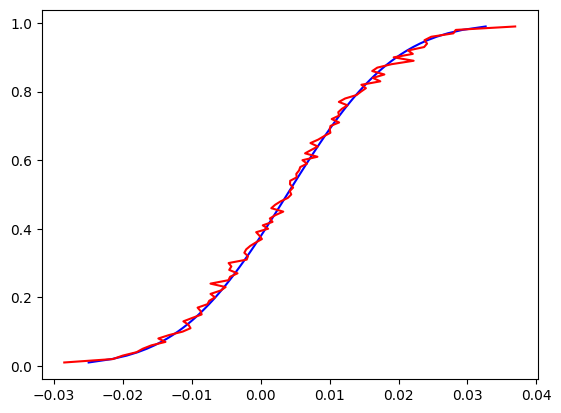

In [61]:
fcn.eval()

input, target = gen_proba(6)

output = fcn(input.cuda())

pixel = (0,0,50,25)
val = input[pixel]
print(val)
m = torch.distributions.normal.Normal(val**2, 0.2*val + 0.0000000001)
x = torch.arange(0.01,1.,0.01)

plt.plot(m.icdf(x), x, color = 'blue')


icdf = output[pixel[0],:,pixel[2],pixel[3]].detach().cpu()

plt.plot(icdf, x, color = 'red')